# Two dimensional FDTD code for constant dielectric materials

In [14]:
"""2D FDTD with YEE-Algorithmus: leapfrog and staggered grid according to 
    Taflove's book
    - in vacuum with Debye material
    - BC: PEC and PML
    - TE-mode

Richard Ciesielski
"""
%load_ext autoreload
%autoreload 2

import numpy
from numpy import pi
import pylab
%matplotlib inline

# Simulation libraries:
import fdtd_core as core
import fdtd_excitations as exc
import fdtd_objects as obj
import fdtd_visualization as vis


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation with a dielectric scatterer, reacting to a short pulse

number of nodes : 301 x 241 = 72541 	 time step : 0.0972212312311 	 cycles : 1029
simulation time left:  100 fs, energy:  1911037.34288
simulation time left:  95 fs, energy:  1907508.18586
simulation time left:  90 fs, energy:  1903411.84419
simulation time left:  85 fs, energy:  1873037.90667
simulation time left:  80 fs, energy:  1856320.92964
simulation time left:  75 fs, energy:  1854653.45639
simulation time left:  70 fs, energy:  1868071.18259
simulation time left:  65 fs, energy:  1898706.42568
simulation time left:  60 fs, energy:  1906645.04062
simulation time left:  55 fs, energy:  1907257.47531
simulation time left:  50 fs, energy:  1907235.41076
simulation time left:  45 fs, energy:  1907134.54349
simulation time left:  40 fs, energy:  1906884.27592
simulation time left:  35 fs, energy:  1816167.9476
simulation time left:  30 fs, energy:  689189.105432
simulation time left:  25 fs, energy:  23891.0136921
simulation time left:  20 fs, energy:  14846.1004684
simulation time l

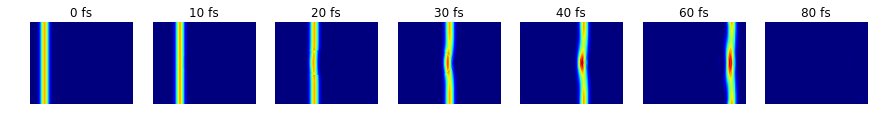

In [19]:
# create a mesh:
lengthx = 25.
lengthy = 20.
Nx = 301                            # number of nodes for the E-field
dx = lengthx / (Nx - 1)
Ny =  int(lengthy / dx + 1)
lengthy = (Ny - 1) * dx             # adjust the length

# produce a staggered grid with NxN nodes:
grid = core.staggered_grid_2D_simple(lengthx, lengthy, Nx, Ny)

# add PMLs:
grid.addPML(1.5, "right", 11., "full")
grid.addPML(1.5, "left", 11., "full")
grid.addPML(1.5, "up", 11.)
grid.addPML(1.5, "down", 11.)

# add scatterer:
wp = 4
wj = 1
gamma = 1
obj.addDielectricCircle(grid, 
    x=10, y=lengthy / 2., R=3., n = 1.5)

# add excitation:
excitations = []
excitations.append(exc.testpulse_x_Exc(x=3.5, H=1, sigma=1, rc=2))

# the time step is calculated based on the vacuum speed of light
# since we use a material with refractive index > 1, we need to reduce it
dt = grid.dt / 2.
grid.dt = dt

t, t_end = 0, 100.1                 # duration of the simulation
cycles = int((t_end - t) / dt)      # total number of cycles
time = numpy.linspace(t, t_end, cycles)

print "number of nodes :",Nx, "x", Ny,"=", Nx*Ny, \
        "\t time step :",dt,  "\t cycles :", cycles

# list of snapshot times
t_list = [0, 10, 20, 30, 40, 60, 80,100]
S_list = [] # numpy.zeros((len(t_list), grid.Ex.shape))


# observation of numerical divergences in Ex,Ey,Hz:
bookkeeping = numpy.zeros(cycles)
w_probe = 3
Ex_w = numpy.zeros(grid.Ex.shape, dtype=complex)
Ey_w = numpy.zeros(grid.Ey.shape, dtype=complex)
Hz_w = numpy.zeros(grid.Hz.shape, dtype=complex)

for i in xrange(cycles):             # main loop
    grid.Ex, grid.Ey, grid.Hz = \
            core.CalculationStep_simple(grid, t, excitations)
    
    # calculate the actual absolute value of the Poynting vector:
    S = numpy.sqrt((grid.Ey* grid.Hz[:, :-1])**2 + 
                                 (grid.Ex[:-1, :-1]  * grid.Hz[:, :-1])**2)
    
    # keep a snapshot
    for t0 in t_list:
        if abs(t-t0) < dt / 2:
            S_list.append(S)
    
    # keep track of the convergence
    bookkeeping[i] = numpy.sum(S)
    
    # calculate the Fourier transform at the frequency w_probe
    Ex_w+= numpy.exp(1j * t * w_probe) * grid.Ex
    Ey_w+= numpy.exp(1j * t * w_probe) * grid.Ey
    Hz_w+= numpy.exp(1j * t * w_probe) * grid.Hz
    
    # print progress:
    if cycles > 20:
        if i % int(cycles / 20) == 0: print "simulation time left: ", int(t_end - t), "fs, energy: ", bookkeeping[i]
            
    t = t + dt

print "done"

# now plot the snapshots
n = len(S_list)

norm = 0.
for i in range(n):
    if norm < S_list[i].max():
        norm = S_list[i].max()

pylab.figure(figsize=(15,3))
for i in range(n):
    pylab.subplot(1,n,i+1)
    pylab.imshow(S_list[i])
    pylab.clim(0, norm)
    pylab.axis('off')
    pylab.title(str(t_list[i]) +' fs')


## Postprocessing and Plotting

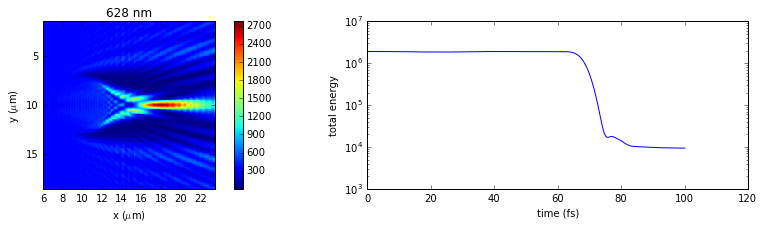

In [20]:
S_w = numpy.sqrt((Ey_w * Hz_w[:, :-1])**2 + 
                                 (Ex_w[:-1, :-1]  * Hz_w[:, :-1])**2)

pylab.figure(figsize=(15,3))
pylab.subplot(121)
#pylab.imshow(abs(S_w))
vis.plot_matrix(abs(S_w), grid, 0, xlim=(6,25))
pylab.colorbar()
pylab.title('%d nm' % (2*pi*3e2 / w_probe))
pylab.xlabel('x ($\mu$m)')
pylab.ylabel('y ($\mu$m)')

pylab.subplot(122)
pylab.semilogy(time, bookkeeping)
pylab.xlabel('time (fs)')
pylab.ylabel('total energy')